In [ ]:
# ╔═══════════════════════════════════════════════════════════════════╗
# ║ 0. SET-UP – upload file & install libraries                       ║
# ╚═══════════════════════════════════════════════════════════════════╝
from google.colab import files
uploaded = files.upload()                          #  ← pick your Excel file
excel_file = list(uploaded.keys())[0]              #  capture the filename

!pip install pandas matplotlib scipy scikit-learn wordcloud --quiet

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from scipy.cluster.hierarchy import linkage, dendrogram
from pandas.plotting import parallel_coordinates
import numpy as np

# Nice default look
sns.set_theme(style="whitegrid", palette="pastel", font_scale=1.2)
df = pd.read_excel(excel_file).loc[:, ~pd.read_excel(excel_file).columns.duplicated()]
print(f"Data loaded →  {df.shape[0]} rows × {df.shape[1]} columns")


Saving Final_output1.xlsx to Final_output1 (2).xlsx
Data loaded →  117 rows × 24 columns


In [ ]:
# run this once — you’ll see all headers exactly as Pandas stores them
for col in df.columns:
    print(col)


Video File
Is the video recorded indoors?_flag
Is the video recorded indoors?_desc
Does the visual text include the name of a medication?_flag
Does the visual text include the name of a medication?_desc
Analyze the tone pitch and emotional expression of the speaker's voice in the audio Based on your analysis categorize the overall sentiment as one of the following: Happy Sad Stressed or Neutral_desc
Is there any swearing or profanity used in the video? If so, give examples._flag
Is there any swearing or profanity used in the video? If so, give examples_desc
Is the person male or female?
What is the age group or demographic profile of the person speaking in the video?_desc
Is the person in the video a content creator/influencer or a healthcare professional such as a nurse or therapist?_desc
Are suicidal thoughts or tendencies discussed in the video? Summarize_flag
Does the speaker explicitly encourage viewers to seek professional help or consult a healthcare provider?_flag
Did the perso

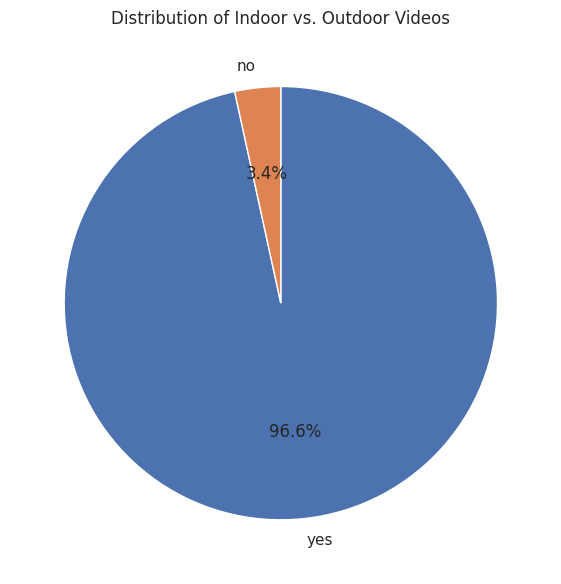

<ipython-input-26-33f3e6f11012>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=medication_counts, x="Mentioned", y="Count", palette="pastel")


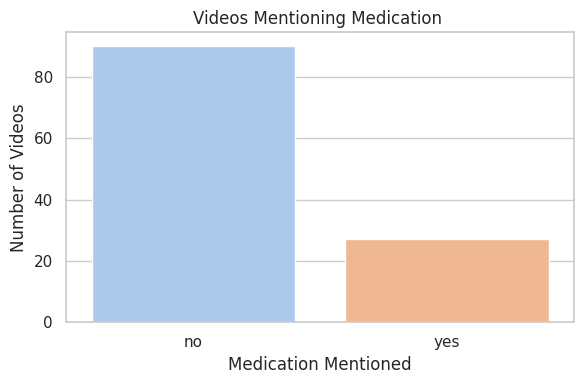

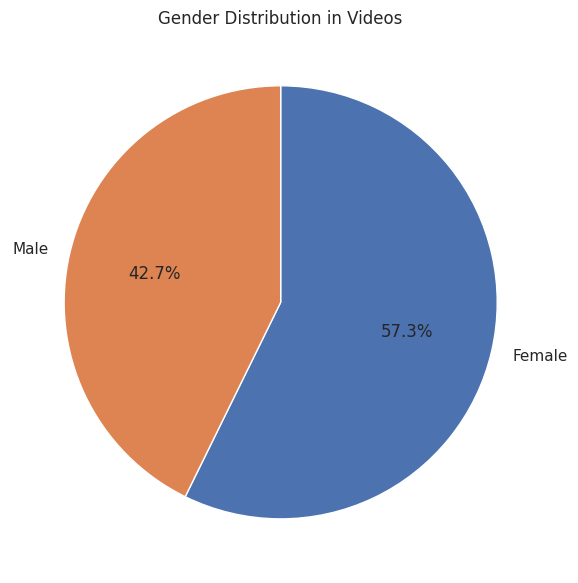

In [ ]:
# 1) Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 2) Read the dataset  (adjust the path if the file lives elsewhere)
df = pd.read_excel("Final_output1.xlsx")

# 3) Set a global Seaborn theme (replaces plt.style.use('seaborn'))
sns.set_theme(style="whitegrid")          # you can swap "whitegrid" for "darkgrid", etc.

# ----------------------------------------------------------------------------------
# 4) Distribution of Indoor vs. Outdoor videos
plt.figure(figsize=(6, 6))
location_counts = df["Is the video recorded indoors?_flag"].value_counts(dropna=False)
location_counts.plot(
    kind="pie",
    autopct="%1.1f%%",
    startangle=90,
    counterclock=False,
    ylabel=""          # hides the default y-label
)
plt.title("Distribution of Indoor vs. Outdoor Videos")
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------------------
# 5) Medication mention in visual text
plt.figure(figsize=(6, 4))
medication_counts = (
    df["Does the visual text include the name of a medication?_flag"]
    .value_counts(dropna=False)
    .rename_axis("Mentioned")
    .reset_index(name="Count")
)
sns.barplot(data=medication_counts, x="Mentioned", y="Count", palette="pastel")
plt.title("Videos Mentioning Medication ")
plt.xlabel("Medication Mentioned")
plt.ylabel("Number of Videos")
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------------------
# 6) Gender distribution
plt.figure(figsize=(6, 6))
gender_counts = df["Is the person male or female?"].value_counts(dropna=False)
gender_counts.plot(
    kind="pie",
    autopct="%1.1f%%",
    startangle=90,
    counterclock=False,
    ylabel=""
)
plt.title("Gender Distribution in Videos")
plt.tight_layout()
plt.show()


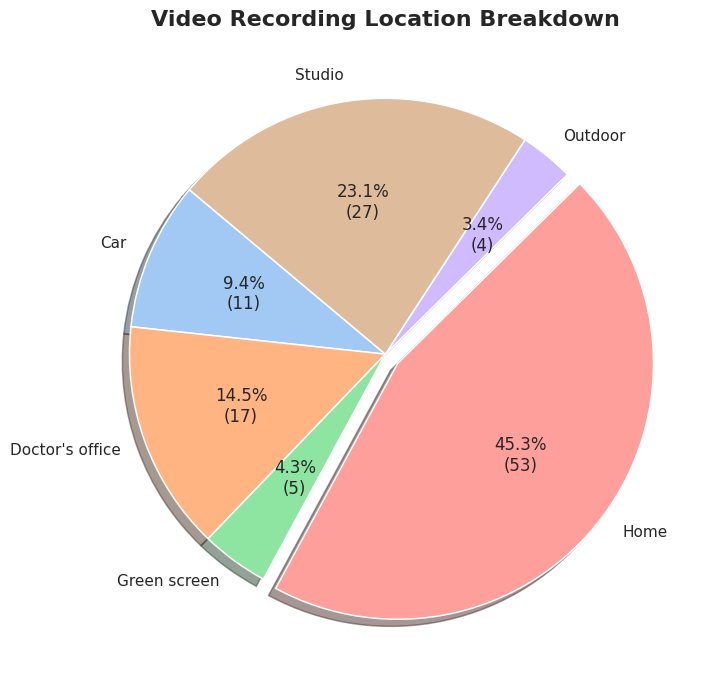

In [ ]:
# ╔════════════════════════════════════════════════════════════════╗
# ║  PIE CHART · Recording Location w/ Percent & Count             ║
# ╚════════════════════════════════════════════════════════════════╝
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

COL = "Is the video recorded indoors?_desc"      # ensure exact match

# 1️⃣  Clean & normalise labels
clean = (
    df[COL]
    .astype(str)
    .str.strip()
    .replace({
        "Outdoor":"Outdoor", "outdoor":"Outdoor",
        "Home":"Home", "home":"Home",
        "Car":"Car", "car":"Car",
        "Doctor's office":"Doctor's office", "doctor's office":"Doctor's office",
        "Green screen":"Green screen", "green screen":"Green screen",
        "Studio":"Studio", "studio":"Studio",
        "nan":"(Blanks)", "":"(Blanks)"
    })
)

order   = ["Car","Doctor's office","Green screen","Home","Outdoor","Studio","(Blanks)"]
counts  = clean.value_counts().reindex(order).dropna()
total   = counts.sum()

# 2️⃣  A pretty palette
colors  = sns.color_palette("pastel", len(counts)).as_hex()

# 3️⃣  Explode largest slice
explode = [0.06 if i == counts.argmax() else 0 for i in range(len(counts))]

# 4️⃣  Helper to format labels
def make_autopct(vals):
    def _autopct(pct):
        idx = int(np.round(pct/100.*len(vals)))  # rough index
        count = int(np.round(pct/100.*total))
        return f"{pct:.1f}%\n({count})"
    return _autopct

# 5️⃣  Plot
plt.figure(figsize=(9,7))
plt.pie(counts,
        labels=counts.index,
        autopct=make_autopct(counts),
        colors=colors,
        explode=explode,
        startangle=140,
        shadow=True,
        wedgeprops={"edgecolor":"white","linewidth":1.1})
plt.title("Video Recording Location Breakdown", fontsize=16, weight="bold")
plt.tight_layout()
plt.show()


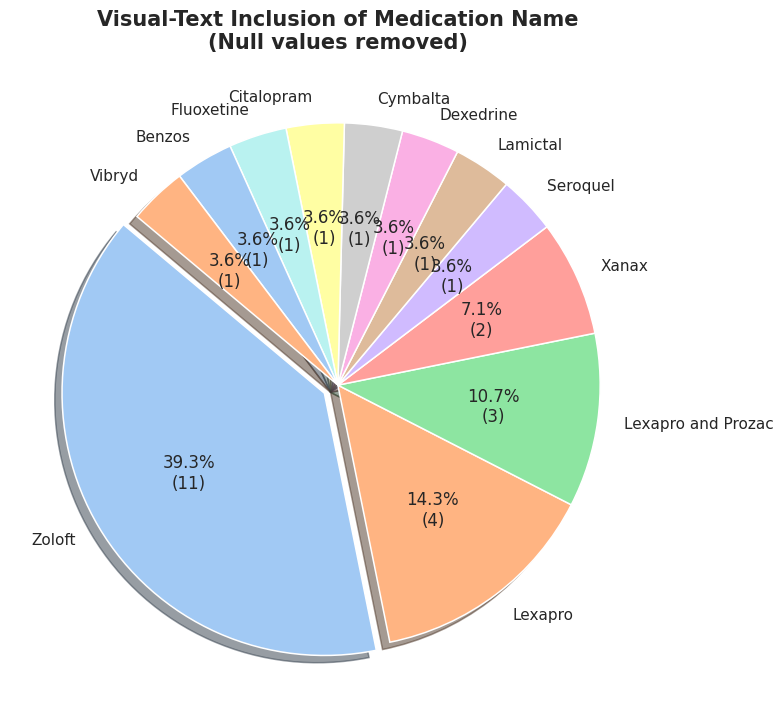

In [ ]:
# ╔══════════════════════════════════════════════════════════════╗
# ║  PIE · Visual-Text Medication Names (NaNs removed)           ║
# ╚══════════════════════════════════════════════════════════════╝
import matplotlib.pyplot as plt, seaborn as sns, numpy as np

COL = "Does the visual text include the name of a medication?_desc"

# 1️⃣  Drop null-ish rows entirely
valid = (
    df[COL]
      .dropna()                               # real NaNs
      .astype(str).str.strip()
      .loc[lambda s: ~s.str.lower().isin(["nan","n/a","not mentioned",""])]
)

# 2️⃣  Build counts
counts = valid.value_counts()
total  = counts.sum()

# 3️⃣  Pick colours & explode largest slice
colors  = sns.color_palette("pastel", len(counts)).as_hex()
explode = [0.06 if i == counts.argmax() else 0 for i in range(len(counts))]

def pct_and_n(p):
    n = int(round(p/100*total))
    return f"{p:.1f}%\n({n})"

# 4️⃣  Plot
plt.figure(figsize=(8,8))
plt.pie(counts,
        labels=counts.index,
        colors=colors,
        explode=explode,
        autopct=pct_and_n,
        shadow=True,
        startangle=140,
        wedgeprops={"edgecolor":"white","linewidth":1.1})
plt.title("Visual-Text Inclusion of Medication Name\n(Null values removed)",
          fontsize=15, weight="bold")
plt.tight_layout()
plt.show()


<ipython-input-48-328e8c3dc991>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=counts.index, y=counts.values,


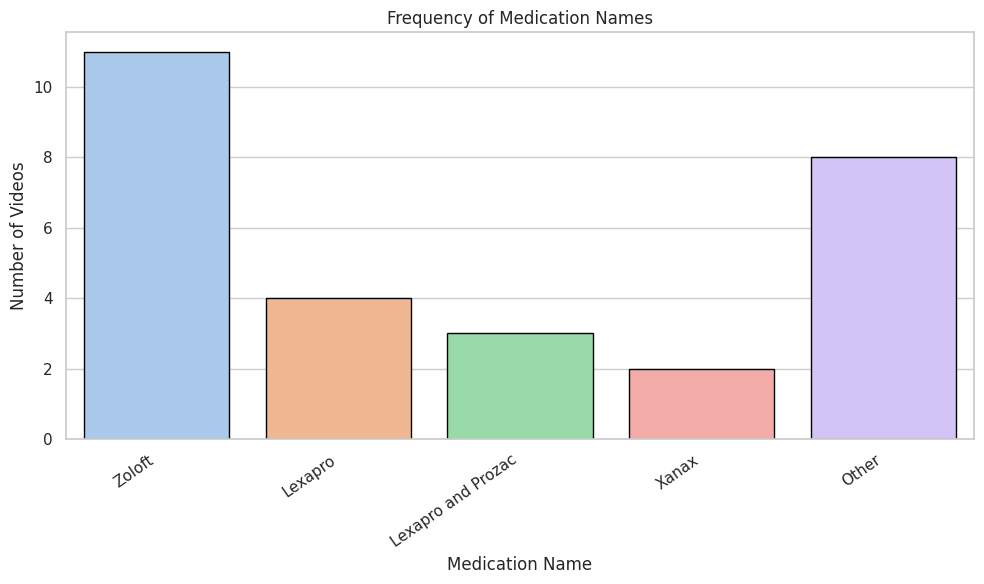

In [ ]:
# ╔════════════════════════════════════════════════════════════╗
# ║  VERTICAL BAR · Medication Names (axes swapped)            ║
# ╚════════════════════════════════════════════════════════════╝
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns, numpy as np

COL = "Does the visual text include the name of a medication?_desc"

# 1️⃣  Clean & count
valid = (
    df[COL]
      .dropna()
      .astype(str).str.strip()
      .loc[lambda s: ~s.str.lower().isin(["nan", "n/a", "not mentioned", ""])]
)
counts = valid.value_counts().sort_values(ascending=False)

# OPTIONAL • lump infrequent names into "Other"
MIN_COUNT = 2
rare_total = counts[counts < MIN_COUNT].sum()
if rare_total:
    counts = pd.concat([counts[counts >= MIN_COUNT],
                        pd.Series({"Other": rare_total})])

# 2️⃣  Plot (vertical bars)
plt.figure(figsize=(10,6))
ax = sns.barplot(x=counts.index, y=counts.values,
                 palette="pastel", edgecolor="black")

#

# 4️⃣  Aesthetics
ax.set(
    title="Frequency of Medication Names",
    xlabel="Medication Name",
    ylabel="Number of Videos"
)
plt.xticks(rotation=35, ha="right")
plt.tight_layout()
plt.show()


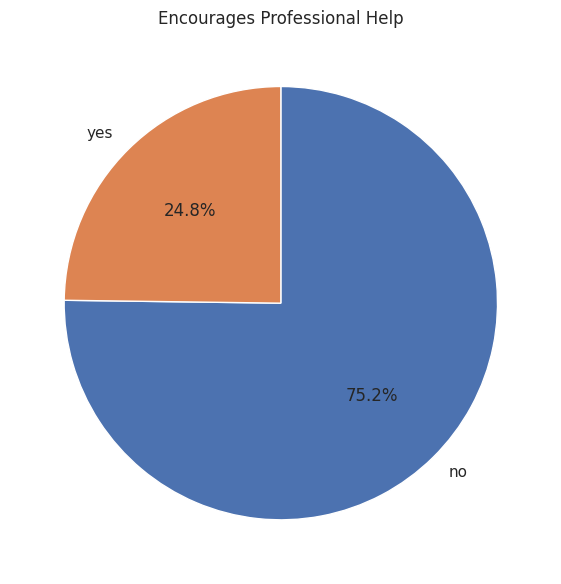

In [ ]:
# 1) Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 2) Read the dataset  (adjust the path if the file lives elsewhere)
df = pd.read_excel("Final_output1.xlsx")

# 3) Set a global Seaborn theme (replaces plt.style.use('seaborn'))
sns.set_theme(style="whitegrid")          # you can swap "whitegrid" for "darkgrid", etc.

# ----------------------------------------------------------------------------------
# 4) Distribution of Indoor vs. Outdoor videos
plt.figure(figsize=(6, 6))
location_counts = df["Does the speaker explicitly encourage viewers to seek professional help or consult a healthcare provider?_flag"].value_counts(dropna=False)
location_counts.plot(
    kind="pie",
    autopct="%1.1f%%",
    startangle=90,
    counterclock=False,
    ylabel=""          # hides the default y-label
)
plt.title("Encourages Professional Help")
plt.tight_layout()
plt.show()

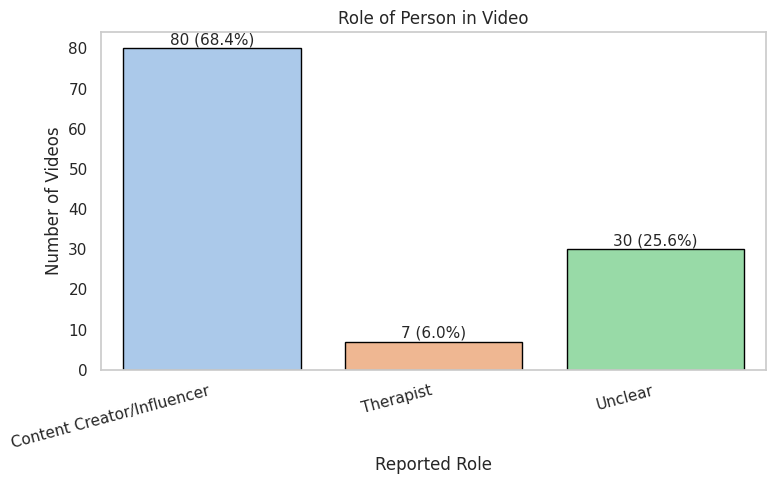

In [ ]:
# ╔════════════════════════════════════════════════════════════╗
# ║  BAR · Role of Person in Video (warning-free, labelled)    ║
# ╚════════════════════════════════════════════════════════════╝
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns, numpy as np

COL = ("Is the person in the video a content creator/influencer or a healthcare "
       "professional such as a nurse or therapist?_desc")

# 1️⃣  Clean the column
role = (
    df[COL]
      .dropna()
      .astype(str).str.strip().str.title()          # Content Creator/Influencer, Therapist, Unclear
      .loc[lambda s: s != ""]
)

counts = role.value_counts().reindex(
    ["Content Creator/Influencer", "Therapist", "Unclear"]
).dropna()

total = counts.sum()

# 2️⃣  Build a small DataFrame for Seaborn
plot_df = counts.reset_index()
plot_df.columns = ["Role", "Count"]

# 3️⃣  Plot — use hue so ‘palette’ is accepted, then hide the legend
plt.figure(figsize=(8,5))
ax = sns.barplot(data=plot_df,
                 x="Role",
                 y="Count",
                 hue="Role",
                 dodge=False,
                 palette="pastel",
                 legend=False,
                 edgecolor="black")
# 🔹  Disable grid lines  🔹
ax.grid(False)
# 4️⃣  Add count + % labels manually
for bar, value in zip(ax.patches, plot_df["Count"]):
    pct = value / total
    ax.text(bar.get_x() + bar.get_width()/2,
            bar.get_height() + 0.2,
            f"{value} ({pct:.1%})",
            ha="center", va="bottom", fontsize=11)

# 5️⃣  Aesthetics
ax.set(title="Role of Person in Video",
       xlabel="Reported Role",
       ylabel="Number of Videos")
plt.xticks(rotation=15, ha="right")
plt.tight_layout()
plt.show()
